slope estimate with the smallest squared error (noise + fitting error) :  2.88


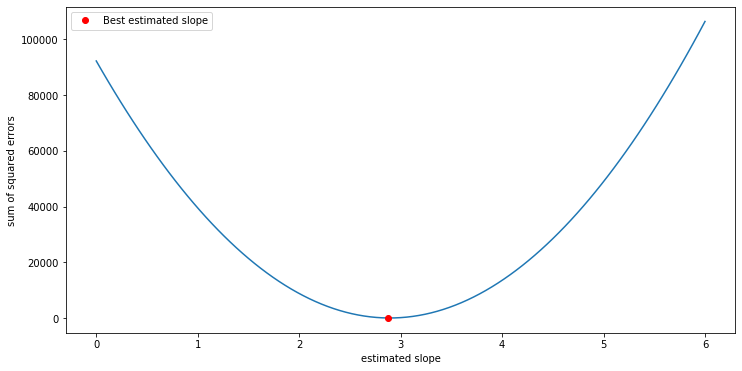

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## let's create some data to play with 
slopeReal = 3 # the real slope is 3
noise = 3
x = np.arange(15) # 15 points for x
y = slopeReal * x + noise * np.random.randn(len(x)) # y = beta * x + some noise (no intercept here)


possibleSlopes = np.linspace(0,6,101)# trying a hundred slopes between 0 and 6
errors = []
for sl in possibleSlopes: # we compute the sum of squared error for each slopes
    yPred = sl*x
    errors.append( sum( yPred - y )**2 )

fitted_slope=possibleSlopes[ np.argmin( errors ) ] # we use np.argmin to find the best slope
min_err=min(errors)

#plotting 
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(possibleSlopes , errors )
ax.plot(fitted_slope , min_err,'ro' ,label='Best estimated slope')
ax.legend(loc='best',fontsize=10)

plt.xlabel('estimated slope')
plt.ylabel('sum of squared errors')
print( 'slope estimate with the smallest squared error (noise + fitting error) : ', fitted_slope )
plt.show()


**Mini-exercice : what are the defaults of this method to find the best $\beta$ ?**
    
 1. this method looks for a fixed set of values : 100 values between 0 and 6. The best slope could be outside this range, or in-between 2 of the tested values
 2. the size of the space of parameters to explore quickly explodes when there is more parameters, becasue we have to test every possible parameter values combination (eg., with 1 parameters, we test 100 values, with 2 parameters we have to test 100\*\*2 = 10 000, with 3 parameters : 100\*\*3 = 1 000 000 , ... )

# Exercise on a real dataset : model the effect of park frequentation on sparrow nest number with a cubic function


Using data from [TESTING THE RISK-DISTURBANCE HYPOTHESIS IN A FRAGMENTED LANDSCAPE: NONLINEAR RESPONSES OF HOUSE SPARROWS TO HUMANS
Fernández-Juricic(2003),BioOne](https://bioone.org/journals/the-condor/volume-105/issue-2/0010-5422(2003)105%5b0316%3aTTRHIA%5d2.0.CO%3b2/TESTING-THE-RISK-DISTURBANCE-HYPOTHESIS-IN-A-FRAGMENTED-LANDSCAPE/10.1650/0010-5422(2003)105[0316:TTRHIA]2.0.CO;2.short)

In this data set we would like to model the relation between the density of house sparrow nests in a park and how popular a park is.

In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

df=pd.read_csv("Human_nuisance.csv")
y=list(df["Breeding density(individuals per ha)"])
X=list(df["Number of pedestrians per ha per min"])

Text(0.5, 0, 'Number of pedestrians per ha per min')

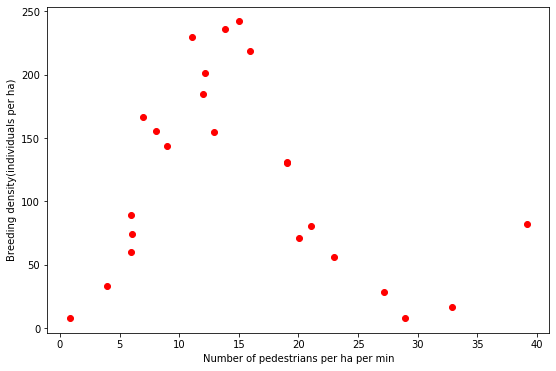

In [6]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(X,y,'ro')
ax.set_ylabel("Breeding density(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")

Perform an OLS regression analysis on this data, to explain the swallow breeding density (response variable) with the number of pedestrian (covariable).

> The relationship between the two variable implies at most a cubic (\*\*3) relation

In [13]:
df=pd.read_csv("Human_nuisance.csv")
df_nuisance=pd.DataFrame()
df_nuisance["Breeding"]=df["Breeding density(individuals per ha)"]
df_nuisance["Number"]=df["Number of pedestrians per ha per min"]
df_nuisance["Number^2"]=df["Number of pedestrians per ha per min"]**2
df_nuisance["Number^3"]=df["Number of pedestrians per ha per min"]**3
y=df_nuisance["Breeding"]
X=df_nuisance[["Number","Number^2","Number^3"]]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.OLS(y, X)# we create the least square fit object
results = model.fit()#we do the actual fit

res=results.summary()
print(res)
LMstat , LMpval , Fstat , Fpval = het_white( results.resid , X )
print("\n\tWhite test for heteroscedasticity p-value:" , LMpval)

                            OLS Regression Results                            
Dep. Variable:               Breeding   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     21.63
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           1.73e-06
Time:                        09:14:09   Log-Likelihood:                -120.22
No. Observations:                  24   AIC:                             248.4
Df Residuals:                      20   BIC:                             253.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -103.6962     36.066     -2.875      0.0

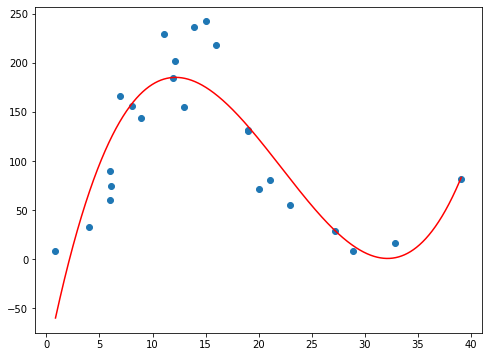

In [14]:
y_d=list(df["Breeding density(individuals per ha)"])
X_d=list(df["Number of pedestrians per ha per min"])
xx=np.arange(min(X_d),max(X_d),0.01)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X_d, y_d, 'o', label="data")
ax.plot(xx, [54.2835*r-3.0726*r**2+0.0462*r**3-103.6962 for r in xx], 'r', label="data")


# Exercise : model choosing on the sparrow nuisance dataset

Come back to the sparrow dataset (`df_nuisance`).

Find the best model possible (i.e., change the degree of the polynomial we try to fit).

In [21]:
from io import StringIO
import scipy.stats as stats

#### a little bit of gymnastic to get this summary saved and usable.
def make_summary_tables( res ):
    """ takes a summary from statsmodel fitting results and turn it into 2 dataFrame.
            - result_general_df : contains general info and fit quality metrics
            - result_fit_df : coefficient values and confidence intervals
    """

    # transform second table to csv and read this as a dataFrame
    result_fit_df = pd.read_csv(StringIO( res.tables[1].as_csv() ), sep=",",index_col=0)

    # first table is trickier because the data is spread on to columns, and there is title line
    L = res.tables[0].as_html().split('\n')
    L.pop(1) # get rid of the title
    tmp = pd.read_html('\n'.join(L) , header=None)[0] # read as a dataframe, but with 4 columns 

    names = list(tmp[0]) + list(tmp[2])[:-2] # columns 0 and 2 are metric names
    values = list(tmp[1]) + list(tmp[3])[:-2] # columns 1 and 3 are the corresponding values
    # NB : I exclude the last 2 elements which are empty 
    
    result_general_df = pd.DataFrame( {'Name': names , 'Value' : values}, index = names , columns=['Value'] )
    
    return result_general_df , result_fit_df


df=pd.read_csv("Human_nuisance.csv")
df_nuisance=pd.DataFrame()
df_nuisance["Breeding"]=df["Breeding density(individuals per ha)"]##[:-2] I tried without the 2 last points

potentialCovariables = []

## adding our covariable from power 1 to power 5
for j in range(1,5+1): # +1 because range excludes the upper limit
    df_nuisance["Number"+"^"+str(j)]=df["Number of pedestrians per ha per min"]**j
    potentialCovariables.append("Number"+"^"+str(j))
   
    
list_co=[]#list of covariable
ordered_loglike_multi=[]
for i in range(len(potentialCovariables)):
    
    # we examine all covariables up to the one of interest
    list_co = potentialCovariables[:i+1]     
    
    y=df_nuisance["Breeding"]
    X=df_nuisance[list_co]#again making it an array 
    X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
    model = sm.OLS(y, X)# we create the least square fit object
    results = model.fit()#we do the actual fit

    ## we transform the summary to access the log-likelihood of the model
    result_general_df , result_fit_df = make_summary_tables( results.summary() )
    
    AdjR2 = results.rsquared_adj
    logLikelihood = results.llf
    print("\tadjusted R-squared:" , AdjR2 , 'log-likelihood:' , logLikelihood)
    
    # add the list of covariable, the log-likelihood and the summary of the fit to our result table
    ordered_loglike_multi.append(['_'.join(list_co),logLikelihood,result_fit_df]) 
    
# the models are ordered by their number of parameters, and that also corresponds to their likelihood

	adjusted R-squared: 0.020972211285679165 log-likelihood: -136.78471098848564
	adjusted R-squared: 0.23333097115711665 log-likelihood: -133.29241280992028
	adjusted R-squared: 0.7290676809937386 log-likelihood: -120.22469703964693
	adjusted R-squared: 0.7368589346481852 log-likelihood: -119.2590320776113
	adjusted R-squared: 0.8509870195109704 log-likelihood: -111.78634335419159


In [22]:
p_value_threshold=0.01## what you would consider as significant or not : 
# i.e if you will consider adding the parameter or not

#we are going through the list of models following their order in goodness of fit
for i in range(1,len(ordered_loglike_multi)): # from model 1 (second model) to the last one
    # We compare this model to the previous one (i-1)
    loglkh1 = ordered_loglike_multi[i  ][1]
    loglkh2 = ordered_loglike_multi[i-1][1]
    LRT = 2*( loglkh1 - loglkh2 )
    # By definition they differ by 1 parameter, so the degree of freedom of the Chi-square distribution is 1
    pval = 1-stats.chi2.cdf( LRT , 1 )#calculating the pvalue that compares the goodness of fit of the two models
    if pval < p_value_threshold:
        print("The log likelihood difference between model {0} and model {1}".format(ordered_loglike_multi[i][0],ordered_loglike_multi[i-1][0]))
        print(" is associated to a P-value={0}\n".format(pval))

    else:
        print("The log likelihood difference between model {0} and model {1}".format(ordered_loglike_multi[i][0],ordered_loglike_multi[i-1][0]))
        print(" is associated to a non-significant P-value={0}\n".format(pval))
        break

The log likelihood difference between model Number^1_Number^2 and model Number^1
 is associated to a P-value=0.008221419278425013

The log likelihood difference between model Number^1_Number^2_Number^3 and model Number^1_Number^2
 is associated to a P-value=3.1828949276224705e-07

The log likelihood difference between model Number^1_Number^2_Number^3_Number^4 and model Number^1_Number^2_Number^3
 is associated to a non-significant P-value=0.1646130179400307



In [23]:
#let's look at our best model
ordered_loglike_multi[2]

['Number^1_Number^2_Number^3',
 -120.22469703964693,
              coef      std err       t      P>|t|     [0.025     0.975] 
                                                                         
 const      -103.6962     36.066     -2.875   0.009   -178.929    -28.463
 Number^1     54.2835      7.523      7.216   0.000     38.591     69.976
 Number^2     -3.0726      0.441     -6.965   0.000     -3.993     -2.152
 Number^3      0.0462      0.007      6.279   0.000      0.031      0.062]